In [ ]:
# Cài thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# 1. Đọc dữ liệu
train_df = pd.read_csv("/content/train.csv", parse_dates=["date"])
valid_df = pd.read_csv("/content/validation.csv", parse_dates=["date"])
test_df = pd.read_csv("/content/test.csv", parse_dates=["date"])

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:", test_df.shape)

Train: (37620, 15)
Valid: (5374, 15)
Test: (10749, 15)


In [ ]:
# 2. Chuẩn bị dữ liệu
features = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc',
            'ticket_price', 'ticket_use', 'capacity', 'month', 'quarter', 'day', 'year']
target = 'total_sales'

X_train = train_df[features].values
y_train = train_df[target].values

X_valid = valid_df[features].values
y_valid = valid_df[target].values

X_test = test_df[features].values
y_test = test_df[target].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_valid = scaler_X.transform(X_valid)
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, 1)).flatten()

X_test = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [ ]:
# 3. Linear Regression
model = LinearRegression()
model.fit(X_train, y_train_scaled)

LinearRegression()

In [ ]:
#4 Dự đoán trên tập validation và test
val_preds_scaled = model.predict(X_valid)
test_preds_scaled = model.predict(X_test)

val_preds = scaler_y.inverse_transform(val_preds_scaled.reshape(-1, 1)).flatten()
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
y_valid_orig = scaler_y.inverse_transform(y_valid_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()

In [ ]:
#5 Đánh giá
val_rmse = np.sqrt(mean_squared_error(y_valid_orig, val_preds))
val_r2 = r2_score(y_valid_orig, val_preds)
val_mae = mean_absolute_error(y_valid_orig, val_preds)

test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_preds))
test_r2 = r2_score(y_test_orig, test_preds)
test_mae = mean_absolute_error(y_test_orig, test_preds)

print(f'Validation RMSE: {val_rmse:.2f}, R²: {val_r2:.4f}, MAE: {val_mae:.2f}')
print(f'Test RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}, MAE: {test_mae:.2f}')

Validation RMSE: 15653772.24, R²: 0.8007, MAE: 7071076.54
Test RMSE: 9279107.16, R²: 0.9119, MAE: 4582749.08


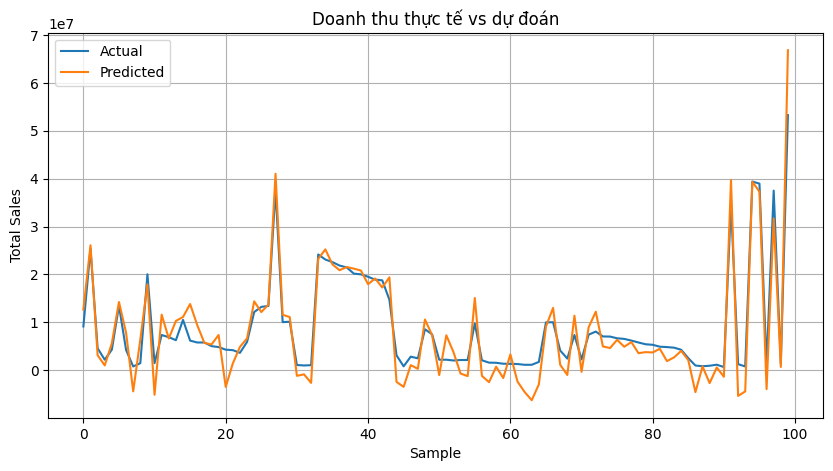

In [ ]:
#6. Vẽ biểu đồ So sánh doanh thu thực tế với dự đoán
test_targets = y_test
test_preds = y_test_pred
plt.figure(figsize=(10,5))
plt.plot(test_targets[:100], label='Actual')
plt.plot(test_preds[:100], label='Predicted')
plt.legend()
plt.title('Doanh thu thực tế vs dự đoán')
plt.xlabel('Sample')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()



In [ ]:
#7. Dự đoán tương lai 30 ngày
last_date = test_df['date'].iloc[-1]

future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30)
future_X_raw = test_df[features].iloc[-30:].copy()
future_X_raw['month'] = future_dates.month
future_X_raw['quarter'] = ((future_dates.month - 1) // 3) + 1
future_X_raw['day'] = future_dates.day
future_X_raw['year'] = future_dates.year
future_X_scaled = scaler_X.transform(future_X_raw.values)
future_preds_scaled = model.predict(future_X_scaled)
future_sales = scaler_y.inverse_transform(future_preds_scaled.reshape(-1, 1)).flatten()

# Tạo DataFrame kết quả
future_df = pd.DataFrame({
    'date': future_dates,
    'total_sales': future_sales,
    'type': 'Forecasted Sales'
})

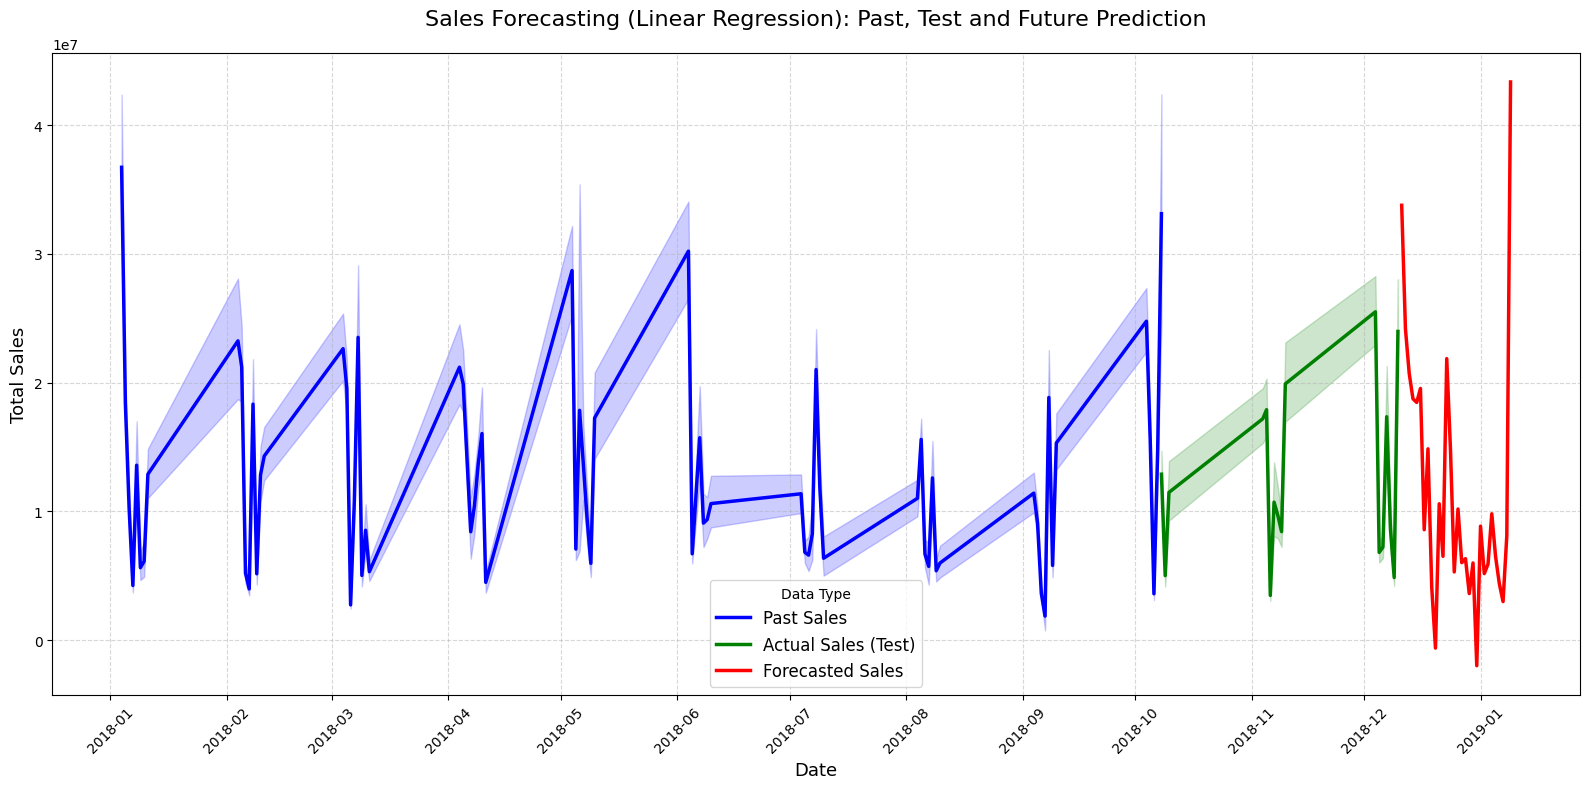

In [21]:
#8. Visualization tổng thể
train_df['type'] = 'Past Sales'
valid_df['type'] = 'Past Sales'
test_df['type'] = 'Actual Sales (Test)'
future_df['type'] = 'Forecasted Sales'


train_plot = train_df[['date', 'total_sales', 'type']]
valid_plot = valid_df[['date', 'total_sales', 'type']]
test_plot = test_df[['date', 'total_sales', 'type']]
future_plot = future_df[['date', 'total_sales', 'type']]


combined_df = pd.concat([train_plot, valid_plot, test_plot, future_plot], ignore_index=True)

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)

#  Định dạng trục thời gian
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # cách mỗi tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting (Linear Regression): Past, Test and Future Prediction', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()
